Installing libraries

In [116]:
!pip install openai
!pip install textblob
!pip install python-dotenv
!pip install fiona 
!pip install geopandas 
!pip install xgboost 
!pip install gensim 
!pip install folium 
!pip install pyLDAvis 
!pip install descartes 
!pip install pandas-bokeh
!pip install pgeocode
!pip install plotly 
!pip install plotly-geo

   ---------------------------------------- 0.0/23.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/23.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/23.7 MB 787.7 kB/s eta 0:00:31
   ---------------------------------------- 0.2/23.7 MB 1.3 MB/s eta 0:00:18
    --------------------------------------- 0.4/23.7 MB 2.2 MB/s eta 0:00:11
   - -------------------------------------- 0.7/23.7 MB 3.3 MB/s eta 0:00:07
   - -------------------------------------- 0.9/23.7 MB 3.4 MB/s eta 0:00:07
   -- ------------------------------------- 1.2/23.7 MB 4.1 MB/s eta 0:00:06
   --- ------------------------------------ 2.1/23.7 MB 6.1 MB/s eta 0:00:04
   ------ --------------------------------- 3.7/23.7 MB 9.5 MB/s eta 0:00:03
   ----------- ---------------------------- 6.7/23.7 MB 15.4 MB/s eta 0:00:02
   --------------- ------------------------ 9.3/23.7 MB 19.1 MB/s eta 0:00:01
   --------------------- ------------------ 12.7/23.7 MB 59.5 MB/s eta 0:00:01
   ----

Importing libraries

In [113]:
import os
import pgeocode
import openai
import pandas as pd
import numpy as np
import time
import logging
from openai import AzureOpenAI
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import pandas_bokeh
import plotly.graph_objects as go

from shapely.geometry import Point

%matplotlib inline
import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from dotenv import load_dotenv
from operator import itemgetter
from textblob import TextBlob
import json
import requests
import copy
import glob
import fileinput

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SXM0326\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\SXM0326\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SXM0326\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SXM0326\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SXM0326\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Initialization

In [74]:
os.chdir('c:\\Users\\SXM0326\\Downloads\\Extract_files')

In [80]:
load_dotenv()
OPENAI_API_KEY = os.getenv("SBD_OPENAI_API_KEY")
API_VERSION = os.getenv("SBD_API_VERSION")
openai.api_key = OPENAI_API_KEY

In [82]:
client = AzureOpenAI(  
                azure_endpoint="https://sbd-genai-apollo-useast2-sbx-openai.openai.azure.com/",  
                api_key=OPENAI_API_KEY, #"1630bbf79d9e44dfb1417053c38cc8ec",    
                api_version=API_VERSION#"2024-02-15-preview"
                )

In [6]:
VENDOR_STOPWORDS=['BIZ',
                  'BV',
                  'CO',
                  'COMP',
                  'COMPANY',
                  'COMPANIES',
                  'CORP',
                  'CORP',
                  'CORPORATE',
                  'STORE',
                  'STORES',
                  'RDC',
                  'BDC',
                  '<DI>',
                  'DFC',
                  'OF',
                  'THE',
                  '(DI)',
                  '<DI>',
                  '<DI>',
                  'DIST',
                  'DISTRIBUTION',
                  '.COM',
                  'CORPORATION',
                  'CONFIDENTIAL',
                  'SERVICE',
                  'SERVICES',
                  'LLC',
                  'LTD',
                  'LLP',
                  'INC',
                  'INCORP',
                  'INCORPORAT',
                  'INCORPORATE',
                  'INCORPORATED',
                  'INCORPORATION',
                  'INTERNATIONAL',
                  'INTL',
                  'INTNL',
                  'LIMITED',
                  'LTD',
                  'LLC',
                  'LTD',
                  'LLP',
                  'MACHINES',
                  'PVT',
                  'PTE',
                  'PRIVATE',
                  'HDWE',
                  'HARDWARE',
                  'HARDWARES',
                  'DROPSHIP',
                  'DROPSHIPPING',
                  'DROPSHIPPER',
                  'DROPSHIPPER',
                  'LOC',
                  'LOCATION',
                  'PT',
                  'POINT',
                  'DTS',
                  'INDUSTRITIES',
                  'INDUSTRIES',
                  'INDUSTRIAL',
                  'INDUSTRY',
                  'DEDC',
                  'VENDOR',
                  'VENDORS',
                  'IVSC',
                  'STATE',
                  'FULFILLMENT',
                  'FULFILLMENTS',
                  'SERVICE',
                  'SERVICES',
                  'DEDC',
                  'TOOL',
                  'TOOLS',
                  'REPAIR',
                  'DOTCOM'
                  ]

Read File

In [7]:
df = pd.read_csv("na_cust_names_1.csv")
df['XFRM_CUST_NAME'] = df['XFRM_CUST_NAME'].str.upper()
df['XFRM_CUST_NAME'] = df['XFRM_CUST_NAME'].apply(lambda x: x.replace('<DI>',''))
df['XFRM_CUST_NAME'] = df['XFRM_CUST_NAME'].apply(lambda x: x.replace('(DI)',''))
df['XFRM_CUST_NAME'] = df['XFRM_CUST_NAME'].apply(lambda x: ' '.join([word for word in x.split() if word not in (VENDOR_STOPWORDS)]))
df.shape

(1517517, 5)

EDA

In [8]:
df.head()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD
0,SAPC11,0004864903,CHAPPEL LANA,L6Y 6A8,CA
1,SAPC11,0004068784,"KELLEY, JUDY",92821,US
2,SAPC11,0001622054,VALLN IRLN POS ONLY OH WAYNE NO ORDERS POS ONLY,44691,US
3,SAPC11,0009158037,KASSANDRA CHRISTENSEN,58723,US
4,SAPC11,0001160480,DGI POS ONLY ID BANNOCK NO ORDERS POS ONLY,83201,US


In [9]:
df.tail()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD
1517512,SAPC11,0004255544,SHIRLEY HIATT,27030,US
1517513,SAPC11,0009124789,ORANGE COUNTY FIRE AND RESCUE,32811,US
1517514,SAPC11,0004862932,ROMAN VRANZEWSKI,H1S 2X6,CA
1517515,SAPC11,0009083400,"HAWES, WARREN",85739,US
1517516,SAPC11,0004135153,R AND W CABINETRY,23462,US


In [10]:
len(df[df['XFRM_CUST_NAME'].str.contains('LOWES')]), len(df[df['XFRM_CUST_NAME'].str.contains('WALMART')]), len(df[df['XFRM_CUST_NAME'].str.contains('HOME DEPOT')]), len(df[df['XFRM_CUST_NAME'].str.contains('AMAZON')]), len(df[df['XFRM_CUST_NAME'].str.contains('AMZN')])

(13395, 22594, 12908, 3420, 0)

Model Instruction

In [11]:
delimiter = '#'
MODEL = "sbd-gpt-4-turbo-128k"
system_message = f"""
You will be provided with customer names, delimited by {delimiter}. \
The name can either be a person's name or retail company name or blank or empty string.\
if the name is a retail company name, it can be nestled in the string.\
If the name is a person's name, output the name as is. \
If the name is a retail company name, extract the company name only without any number \
or special character or place name or state name or country name or the direction name or any \
abbreviated names or any included acquired company names and output the company name.\
If the name is blank or empty string, then output 'No name found.'
Output has to strictly follow the instruction.
"""

In [12]:
temp_df = df[df['XFRM_CUST_NAME'].str.contains('LOWES')]
temp_df

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD
677,SAPC11,0002822247,LOWES 2247,15102,US
880,SAPC11,0003409092,ANNA ORBEN FIELD OPERATIONS MANAGER LOWES,28037,US
899,SAPC11,0002822591,LOWES 2591,37620,US
1289,SAPC11,0005602776,LOWES 3066,N7S 6M8,CA
1593,SAPC11,0002822613,LOWES 2613,16830,US
...,...,...,...,...,...
1515612,SAPC11,0002822284,LOWES 2284,11234,US
1515614,SAPC11,0002821181,LOWES 1181,36066,US
1516683,SAPC11,0001909614,LOWES 3708 3708,K1B 3K5,CA
1516760,SAPC11,0002821099,LOWES 1099,80922,US


In [13]:
def get_completion_from_messages(messages, model=MODEL, temperature=0, max_tokens=4096):
    response = client.chat.completions.create(model=MODEL,
                    messages= messages,
                    temperature=0,
                    max_tokens=max_tokens,
                    top_p=0.95,
                    frequency_penalty=0,
                    presence_penalty=0,
                    stop=None)
    return response.choices[0].message.content  

In [14]:
len(temp_df)

13395

In [15]:
refined_name_list = []
start_idx = 0
for curr_idx, name in enumerate(temp_df['XFRM_CUST_NAME'].values.tolist()):
    user_message_1 = f"""Extract the company name for {name} """
    messages =  [
    {'role':'system',
     'content': system_message},
    {'role':'user',
     'content': f"{delimiter}{user_message_1}{delimiter}"},
    ]
    response = get_completion_from_messages(messages)
    refined_name_list.append((name, response))
    if curr_idx % 100 == 0 and curr_idx > 0:
        work_df = copy.deepcopy(temp_df.iloc[start_idx : curr_idx + 1])
        work_df['REFINED_XFRM_CUST_NAME'] = [e[1] for e in refined_name_list]
        work_df['REFINED_XFRM_CUST_NAME'] = work_df['REFINED_XFRM_CUST_NAME'].apply(lambda x : x.upper().replace("'", ""))
        work_df.sort_values(by = ['XFRM_PSTL_CD_1'], inplace = True)
        print(curr_idx)
        start_idx = curr_idx + 1
        work_df.to_csv(f"temp_file_{curr_idx}.csv", index = False)
        refined_name_list = []

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300


In [16]:
refined_name_list[:20]

[('LOWES 2752', 'LOWES'),
 ('LOWES 677', 'LOWES'),
 ('LOWES SUPERMARKET 029', 'LOWES'),
 ('LOWES CRFT', 'LOWES'),
 ('LOWES 2878', 'LOWES'),
 ('LOWES (RONA) 83097 83097', 'LOWES'),
 ('LOWES SUPERMARKET 65', 'LOWES'),
 ('LOWES 1648', 'LOWES'),
 ('LOWES #0332', 'LOWES'),
 ('LOWES 3313 3313', 'LOWES'),
 ('LOWES', 'LOWES'),
 ('LOWES 965 S JAX', 'LOWES'),
 ('CTN DIR LOWES 1415 1415', 'LOWES'),
 ('LOWES 990', 'LOWES'),
 ('LOWES 1043', 'LOWES'),
 ('LOWES (RONA) 88009 88009', 'LOWES'),
 ('LOWES (RONA) 83201 83201', 'LOWES'),
 ('LOWES 547', 'LOWES'),
 ('LOWES 1567', 'LOWES'),
 ('LOWES #0301', 'LOWES')]

In [6]:
with open('temp.csv', 'w') as fout, fileinput.input(glob.glob(os.path.join(os.getcwd(), 'temp_file*.csv'))) as fin:
    for line in fin:
        fout.write(line)

In [7]:
df_lowes = pd.read_csv("temp.csv")
df_lowes[df_lowes['SRC_SYS_KEY'] == 'SRC_SYS_KEY']
df_lowes = df_lowes[df_lowes['SRC_SYS_KEY'] != 'SRC_SYS_KEY']
df_lowes.columns = ['SRC_SYS_KEY',	
                    'CUST_NBR',	
                    'XFRM_CUST_NAME',	
                    'XFRM_PSTL_CD_1',	
                    'XFRM_CNTRY_CD',	
                    'REFINED_XFRM_CUST_NAME'
                ]
df_lowes.shape

(13301, 6)

In [8]:
df_lowes.head()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME
0,EXCEL_QADDB,SOS02417,"LOWES SCOTT TOWNSHIP, PA",15106,US,LOWES
1,EXCEL_QADDB,SOS02869,"LOWES WHITEVILLE, NC",28472,US,LOWES
2,EXCEL_QADDB,SOS01725,"LOWES NE AUSTIN, TX",78753,US,LOWES
3,EXCEL_QADDB,SOS03348,LOWES CENTRAL DELIVERY TERMINAL,29492,US,LOWES
4,EXCEL_QADDB,LWS-2786,"LOWES S SAN ANTONIO, TX",78224,US,LOWES


In [9]:
df_lowes.tail()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME
13428,EXCEL_QADDB,SOS00004,"LOWES RAINIER, WA",98144,US,LOWES
13429,EXCEL_QADDB,SOS02927,LOWES HOME IMPROVEMENT,12534,US,Lowe's
13430,EXCEL_QADDB,LWS-2524,"LOWES GREENVILLE, OH",45331,US,LOWES
13431,EXCEL_QADDB,SOS01721,"LOWES SOUTHAVEN, MS",38671,US,LOWES
13432,EXCEL_QADDB,SOS00424,"LOWES SALISBURY, MD",21801,US,LOWES


In [10]:
df_lowes['REFINED_XFRM_CUST_NAME'] = df_lowes['REFINED_XFRM_CUST_NAME'].apply(lambda x : x.upper().replace("'", "").replace("\r", " ").replace("\n", " ").replace("#NO NAME FOUND.", "").strip())
df_lowes.sort_values(by = ['XFRM_PSTL_CD_1'], inplace=True)
df_lowes.head()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME
4547,INFORXA,3308,#1916 LOWES,01035,US,LOWES
10725,INFORXA,12840,#1916 LOWES HADLEY MA,01035,US,LOWES
11139,INFORXA,3308,#1916 LOWES HADLEY MA,01035,US,LOWES
9059,INFORXA,3308,#1916 LOWES HADLEY,01035,US,LOWES
9175,EXCEL_QADDB,SOS01916,"LOWES HADLEY, MA",01035,US,LOWES


In [11]:
df_lowes.groupby(['REFINED_XFRM_CUST_NAME'])['REFINED_XFRM_CUST_NAME'].value_counts()

REFINED_XFRM_CUST_NAME
ACE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [12]:
df_lowes['REFINED_XFRM_CUST_NAME'] = np.where(df_lowes['REFINED_XFRM_CUST_NAME'].str.contains('LOWES BALLWIN'), 'LOWES', df_lowes['REFINED_XFRM_CUST_NAME'])

In [13]:
df_lowes['REFINED_XFRM_CUST_NAME'].drop_duplicates().to_list()

['LOWES',
 'LOWES#LOWES',
 'LOWES MAERSK CHESAPEAKE TRANSLOAD 3507    COMPANY NAME: LOWES',
 'LOWES MAERSK CHESAPEAKE TRANSLOAD',
 'LOWES TRUE VALUE',
 'LOWES FOOD',
 'LOWES # FAO NATHAN',
 'NO NAME FOUND.',
 'LOWES COMPANIES',
 'LOWES # NO NAME FOUND.',
 'LOWES#',
 'LOWES JOME IMPROVEMENT',
 'LOWES # NO NAME FOUND. # NO NAME FOUND.',
 'MTD PRODUCTS',
 'LOWES PRO SPLY',
 'ACE',
 'LOWES FLEXE',
 'LOWES#HUFFY',
 'LOWES MARKET',
 'LOWES FAMILY CENTER ACE',
 'LOWES  RAYMOND',
 'ACE HARDWARE  NO NAME FOUND.',
 'LOWES FAMILY CENTER',
 'ACE HARDWARELOWES ACE    THE INPUT SEEMS TO CONTAIN TWO RETAIL COMPANY NAMES CONCATENATED TOGETHER WITHOUT PROPER DELIMITERS. HOWEVER, BASED ON THE INSTRUCTIONS, WE NEED TO EXTRACT THE COMPANY NAME WITHOUT ANY NUMBERS, SPECIAL CHARACTERS, PLACE NAMES, STATE NAMES, COUNTRY NAMES, DIRECTION NAMES, ABBREVIATED NAMES, OR INCLUDED ACQUIRED COMPANY NAMES.    THE TWO COMPANY NAMES ARE "ACE HARDWARE" AND "LOWES." THEREFORE, THE OUTPUT SHOULD BE:    ACE HARDWARE  LOWES

In [14]:
df_lowes['REFINED_XFRM_CUST_NAME'] = np.where(df_lowes['REFINED_XFRM_CUST_NAME'].str.contains('LOWES'), 'LOWES', df_lowes['REFINED_XFRM_CUST_NAME'])

In [15]:
df_lowes['REFINED_XFRM_CUST_NAME'] = np.where(df_lowes['REFINED_XFRM_CUST_NAME'].str.contains('RONA'), 'LOWES', df_lowes['REFINED_XFRM_CUST_NAME'])

In [16]:
df_lowes['REFINED_XFRM_CUST_NAME'].drop_duplicates().to_list()

['LOWES',
 'NO NAME FOUND.',
 'MTD PRODUCTS',
 'ACE',
 'ACE HARDWARE  NO NAME FOUND.']

In [17]:
df_lowes[df_lowes['REFINED_XFRM_CUST_NAME'] == 'NO NAME FOUND.']

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME
12270,SAPC11,0001016828,LOWES POS ACCOUNT ONLY,28656,US,NO NAME FOUND.
5475,SAPC11,0004074221,DEVIN SOLOWES,35006,US,NO NAME FOUND.
1121,SAPC11,0004185243,"CLOWES, GEORGE",72023,US,NO NAME FOUND.
6115,INFORXA,12840,"#2479 LOWES BRIGHTON,",80601,US,NO NAME FOUND.
4829,SAPC11,0004721481,LOWES KATHRYN DEGROOT,L2H 0G5,CA,NO NAME FOUND.
1192,SAPC11,0004849282,"BREWER CLOWES,MICHEAL",V5M 3Y7,CA,NO NAME FOUND.


In [18]:
df_lowes = df_lowes[~df_lowes['XFRM_CUST_NAME'].isin(['DEVIN SOLOWES', 'CLOWES, GEORGE', 'BREWER CLOWES,MICHEAL'])]
df_lowes[df_lowes['REFINED_XFRM_CUST_NAME'] == 'NO NAME FOUND.']

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME
12270,SAPC11,0001016828,LOWES POS ACCOUNT ONLY,28656,US,NO NAME FOUND.
6115,INFORXA,12840,"#2479 LOWES BRIGHTON,",80601,US,NO NAME FOUND.
4829,SAPC11,0004721481,LOWES KATHRYN DEGROOT,L2H 0G5,CA,NO NAME FOUND.


In [19]:
df_lowes['REFINED_XFRM_CUST_NAME'] = np.where(df_lowes['XFRM_CUST_NAME'].str.contains('LOWES'), 'LOWES', df_lowes['REFINED_XFRM_CUST_NAME'])

In [20]:
df_lowes['REFINED_XFRM_CUST_NAME'].drop_duplicates().to_list()

['LOWES']

In [21]:
df_lowes[df_lowes['XFRM_PSTL_CD_1'] == 'V9B 2P3']

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME
3682,SAPC11,0005604333,LOWES (RONA) 83702 83702,V9B 2P3,CA,LOWES
1804,SAPC11,0004831711,LOWES HOME IMPROVEMENT 3702,V9B 2P3,CA,LOWES
12022,SAPC11,0001909573,LOWES 3702 SWK CLOSED PER MKTG 05032021,V9B 2P3,CA,LOWES
3767,SAPC11,0001930688,LOWES (RONA) 83702 83702,V9B 2P3,CA,LOWES
11872,SAPC11,0001205326,LOWES 3702 3702,V9B 2P3,CA,LOWES
3697,SAPC11,0001909575,LOWES 3702 3702,V9B 2P3,CA,LOWES
4273,SAPC11,0001909574,LOWES 3702 3702,V9B 2P3,CA,LOWES
12741,SAPC11,0001204940,LOWES 3702 3702,V9B 2P3,CA,LOWES
6925,SAPC11,0001213291,LOWES (RONA) 83702 83702,V9B 2P3,CA,LOWES
5416,SAPC11,0005604196,LOWES 3702 3702,V9B 2P3,CA,LOWES


In [22]:
df_lowes.groupby(['XFRM_PSTL_CD_1', 'XFRM_CNTRY_CD', 'REFINED_XFRM_CUST_NAME']).count()

,,,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME
XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,,,
01035,US,LOWES,6,6,6
01082,US,LOWES,6,6,6
01129,US,LOWES,5,5,5
01453,US,LOWES,6,6,6
01581,US,LOWES,6,6,6
...,...,...,...,...,...
V9B 2P3,CA,LOWES,11,11,11
V9B 2P3,CA,LOWES,4,4,4
V9T 4K6,CA,LOWES,11,11,11


In [23]:
df_lowes[df_lowes['XFRM_PSTL_CD_1'] == '01035']

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME
4547,INFORXA,3308,#1916 LOWES,01035,US,LOWES
10725,INFORXA,12840,#1916 LOWES HADLEY MA,01035,US,LOWES
11139,INFORXA,3308,#1916 LOWES HADLEY MA,01035,US,LOWES
9059,INFORXA,3308,#1916 LOWES HADLEY,01035,US,LOWES
9175,EXCEL_QADDB,SOS01916,"LOWES HADLEY, MA",01035,US,LOWES
5376,SAPC11,0002821916,LOWES 1916,01035,US,LOWES


In [24]:
df_lowes['CUST_GOLDEN_REC_KEY'] = df_lowes[['XFRM_CNTRY_CD', 'XFRM_PSTL_CD_1', 'REFINED_XFRM_CUST_NAME']].apply(lambda x: '~'.join(x), axis=1)

In [25]:
df_lowes.sort_values(by = ['CUST_GOLDEN_REC_KEY'], inplace=True)
df_lowes.reset_index(drop = True, inplace = True)

In [26]:
df_lowes.head()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY
0,INFORXA,16257,RONALOWES,J4B 8H7,CA,LOWES,CA~J4B 8H7 ~LOWES
1,INFORXA,7991,LOWES #3708,K1B 3K5,CA,LOWES,CA~K1B 3K5 ~LOWES
2,INFORXA,16257,LOWES #3708 GLOUCESTER,K1B 3K5,CA,LOWES,CA~K1B 3K5 ~LOWES
3,SAPC11,0001204973,LOWES 3708 3708,K1B 3K5,CA,LOWES,CA~K1B 3K5~LOWES
4,SAPC11,0001930716,LOWES (RONA) 83708 83708,K1B 3K5,CA,LOWES,CA~K1B 3K5~LOWES


In [27]:
df_lowes.tail()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY
13293,INFORXA,3308,"#1985 LOWES FAIRBANKS, AK",99701,US,LOWES,US~99701~LOWES
13294,SAPC11,0002821985,LOWES 1985 LOWES FAIRBANKS,99701,US,LOWES,US~99701~LOWES
13295,INFORXA,3308,"#1985 LOWES FAIRBANKS, AK",99701,US,LOWES,US~99701~LOWES
13296,INFORXA,3308,#1985 LOWES FAIRBANKS,99701,US,LOWES,US~99701~LOWES
13297,SAPC11,0002820964,LOWES IMPORT CONSOL PROG,^^,US,LOWES,US~^^~LOWES


In [28]:
df_lowes['CUST_GOLDEN_REC_KEY'].value_counts()

CUST_GOLDEN_REC_KEY
US~28659~LOWES    58
US~21286~LOWES    54
US~28697~LOWES    40
US~31601~LOWES    37
US~45840~LOWES    36
                  ..
US~71203~LOWES     1
US~70520~LOWES     1
US~64504~LOWES     1
US~63780~LOWES     1
US~^^~LOWES        1
Name: count, Length: 2321, dtype: int64

In [31]:
df_lowes[df_lowes['XFRM_PSTL_CD_1'] == '45840']

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY
8281,EXCEL_QADDB,LWS-990,LOWES OHIO,45840,US,LOWES,US~45840~LOWES
8282,INFORXA,3308,"#1045 LOWES FINDLAY, OH",45840,US,LOWES,US~45840~LOWES
8283,INFORXA,8724,#990 LOWES FINDLAY,45840,US,LOWES,US~45840~LOWES
8284,SAPC11,0002820262,LOWES #0262,45840,US,LOWES,US~45840~LOWES
8285,SAPC11,0001033611,LOWES 990 PC,45840,US,LOWES,US~45840~LOWES
8286,SAPC11,0001031595,LOWES 990 VEC,45840,US,LOWES,US~45840~LOWES
8287,INFORXA,3308,"#990 LOWES FINDLEY, OH",45840,US,LOWES,US~45840~LOWES
8288,SAPC11,0001912310,LOWES DC 990 FULL CTNR,45840,US,LOWES,US~45840~LOWES
8289,SAPC11,0001033649,LOWES 990 N JAX,45840,US,LOWES,US~45840~LOWES
8290,SAPC11,0002820990,LOWES #990,45840,US,LOWES,US~45840~LOWES


In [29]:
len(df_lowes['CUST_GOLDEN_REC_KEY'].drop_duplicates().values.tolist()), len(df_lowes['CUST_GOLDEN_REC_KEY'].values.tolist())

(2321, 13298)

In [32]:
df_lowes[df_lowes['XFRM_PSTL_CD_1'] == 'V9B 2P3']

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY
933,SAPC11,0001909574,LOWES 3702 3702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
934,SAPC11,0001213292,LOWES (RONA) 83702 83702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
935,SAPC11,0005604196,LOWES 3702 3702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
936,SAPC11,0001930688,LOWES (RONA) 83702 83702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
937,SAPC11,0001204940,LOWES 3702 3702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
938,SAPC11,0001909575,LOWES 3702 3702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
939,SAPC11,0001205326,LOWES 3702 3702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
940,SAPC11,0001909573,LOWES 3702 SWK CLOSED PER MKTG 05032021,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
941,SAPC11,0004831711,LOWES HOME IMPROVEMENT 3702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES
942,SAPC11,0005604333,LOWES (RONA) 83702 83702,V9B 2P3,CA,LOWES,CA~V9B 2P3~LOWES


In [30]:
df_lowes[df_lowes['REFINED_XFRM_CUST_NAME'] == 'ACE']

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY


In [36]:
nomi_ca = pgeocode.Nominatim("ca")
nomi_us = pgeocode.Nominatim("us")

dfcazip = df_lowes[df_lowes.XFRM_CNTRY_CD == 'CA']["XFRM_PSTL_CD_1"].apply(lambda x:nomi_ca.query_postal_code(x))
df_lowes_ca = pd.concat([df_lowes[df_lowes.XFRM_CNTRY_CD == 'CA'], dfcazip], axis="columns")

dfuszip = df_lowes[df_lowes.XFRM_CNTRY_CD == 'US']["XFRM_PSTL_CD_1"].apply(lambda x:nomi_us.query_postal_code(x))
df_lowes_us = pd.concat([df_lowes[df_lowes.XFRM_CNTRY_CD == 'US'], dfuszip], axis="columns")

df_lowes_ca.head()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,INFORXA,16257,RONALOWES,J4B 8H7,CA,LOWES,CA~J4B 8H7 ~LOWES,J4B,CA,Boucherville,Quebec,QC,Montérégie,16.0,Boucherville,58033.0,45.5910,-73.4361,4.0
1,INFORXA,7991,LOWES #3708,K1B 3K5,CA,LOWES,CA~K1B 3K5 ~LOWES,K1B,CA,Gloucester (Blackburn Hamlet / Pine View),Ontario,ON,Gloucester,NaN,NaN,NaN,45.4284,-75.5875,6.0
2,INFORXA,16257,LOWES #3708 GLOUCESTER,K1B 3K5,CA,LOWES,CA~K1B 3K5 ~LOWES,K1B,CA,Gloucester (Blackburn Hamlet / Pine View),Ontario,ON,Gloucester,NaN,NaN,NaN,45.4284,-75.5875,6.0
3,SAPC11,0001204973,LOWES 3708 3708,K1B 3K5,CA,LOWES,CA~K1B 3K5~LOWES,K1B,CA,Gloucester (Blackburn Hamlet / Pine View),Ontario,ON,Gloucester,NaN,NaN,NaN,45.4284,-75.5875,6.0
4,SAPC11,0001930716,LOWES (RONA) 83708 83708,K1B 3K5,CA,LOWES,CA~K1B 3K5~LOWES,K1B,CA,Gloucester (Blackburn Hamlet / Pine View),Ontario,ON,Gloucester,NaN,NaN,NaN,45.4284,-75.5875,6.0


In [37]:
df_lowes_us.head()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
958,INFORXA,3308,#1916 LOWES,01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0
959,INFORXA,12840,#1916 LOWES HADLEY MA,01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0
960,SAPC11,0002821916,LOWES 1916,01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0
961,INFORXA,3308,#1916 LOWES HADLEY MA,01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0
962,EXCEL_QADDB,SOS01916,"LOWES HADLEY, MA",01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0


In [39]:
df_lowes_ext_0 = pd.concat([df_lowes_us, df_lowes_ca], axis=0)
df_lowes_ext_0.head()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
958,INFORXA,3308,#1916 LOWES,01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0
959,INFORXA,12840,#1916 LOWES HADLEY MA,01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0
960,SAPC11,0002821916,LOWES 1916,01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0
961,INFORXA,3308,#1916 LOWES HADLEY MA,01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0
962,EXCEL_QADDB,SOS01916,"LOWES HADLEY, MA",01035,US,LOWES,US~01035~LOWES,01035,US,Hadley,Massachusetts,MA,Hampshire,15.0,NaN,NaN,42.3606,-72.5715,4.0


In [42]:
df_lowes_ext_0.columns = [col.upper() for col in df_lowes_ext_0]
df_lowes_ext_0.columns

Index(['SRC_SYS_KEY', 'CUST_NBR', 'XFRM_CUST_NAME', 'XFRM_PSTL_CD_1',
       'XFRM_CNTRY_CD', 'REFINED_XFRM_CUST_NAME', 'CUST_GOLDEN_REC_KEY',
       'POSTAL_CODE', 'COUNTRY_CODE', 'PLACE_NAME', 'STATE_NAME', 'STATE_CODE',
       'COUNTY_NAME', 'COUNTY_CODE', 'COMMUNITY_NAME', 'COMMUNITY_CODE',
       'LATITUDE', 'LONGITUDE', 'ACCURACY'],
      dtype='object')

In [44]:
df_lowes_ext_1 = df_lowes_ext_0[['SRC_SYS_KEY', 'CUST_NBR', 'XFRM_CUST_NAME', 'XFRM_PSTL_CD_1',
       'XFRM_CNTRY_CD', 'REFINED_XFRM_CUST_NAME', 'CUST_GOLDEN_REC_KEY','COUNTY_NAME', 'LATITUDE', 'LONGITUDE' ]]
df_lowes_ext_1.head()

,SRC_SYS_KEY,CUST_NBR,XFRM_CUST_NAME,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY,COUNTY_NAME,LATITUDE,LONGITUDE
958,INFORXA,3308,#1916 LOWES,01035,US,LOWES,US~01035~LOWES,Hampshire,42.3606,-72.5715
959,INFORXA,12840,#1916 LOWES HADLEY MA,01035,US,LOWES,US~01035~LOWES,Hampshire,42.3606,-72.5715
960,SAPC11,0002821916,LOWES 1916,01035,US,LOWES,US~01035~LOWES,Hampshire,42.3606,-72.5715
961,INFORXA,3308,#1916 LOWES HADLEY MA,01035,US,LOWES,US~01035~LOWES,Hampshire,42.3606,-72.5715
962,EXCEL_QADDB,SOS01916,"LOWES HADLEY, MA",01035,US,LOWES,US~01035~LOWES,Hampshire,42.3606,-72.5715


In [56]:
df_lowes_ext_2 = df_lowes_ext_1[['XFRM_PSTL_CD_1',	
                                 'XFRM_CNTRY_CD',	
                                 'REFINED_XFRM_CUST_NAME',	
                                 'CUST_GOLDEN_REC_KEY',	
                                 'COUNTY_NAME',	
                                 'LATITUDE',	
                                 'LONGITUDE']].drop_duplicates()
df_lowes_ext_2.shape

(2321, 7)

In [58]:
df_lowes_ext_2["Coordinates"] = list(zip(df_lowes_ext_2.LONGITUDE, df_lowes_ext_2.LATITUDE))
df_lowes_ext_2["Coordinates"] = df_lowes_ext_2["Coordinates"].apply(Point)
df_lowes_ext_2.head()

,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY,COUNTY_NAME,LATITUDE,LONGITUDE,Coordinates
958,01035,US,LOWES,US~01035~LOWES,Hampshire,42.3606,-72.5715,POINT (-72.5715 42.3606)
964,01082,US,LOWES,US~01082~LOWES,Hampshire,42.2618,-72.2583,POINT (-72.2583 42.2618)
970,01129,US,LOWES,US~01129~LOWES,Hampden,42.1223,-72.4876,POINT (-72.4876 42.1223)
975,01453,US,LOWES,US~01453~LOWES,Worcester,42.5274,-71.7563,POINT (-71.7563 42.5274)
981,01581,US,LOWES,US~01581~LOWES,Worcester,42.2679,-71.6176,POINT (-71.6176 42.2679)


In [97]:
gdf_ca = gpd.GeoDataFrame(df_lowes_ext_2[df_lowes_ext_2.XFRM_CNTRY_CD == 'CA'], geometry="Coordinates")
gdf_us = gpd.GeoDataFrame(df_lowes_ext_2[df_lowes_ext_2.XFRM_CNTRY_CD == 'US'], geometry="Coordinates")


In [99]:
gdf_ca.head()

,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY,COUNTY_NAME,LATITUDE,LONGITUDE,Coordinates
0,J4B 8H7,CA,LOWES,CA~J4B 8H7 ~LOWES,Montérégie,45.5910,-73.4361,POINT (-73.4361 45.591)
1,K1B 3K5,CA,LOWES,CA~K1B 3K5 ~LOWES,Gloucester,45.4284,-75.5875,POINT (-75.5875 45.4284)
3,K1B 3K5,CA,LOWES,CA~K1B 3K5~LOWES,Gloucester,45.4284,-75.5875,POINT (-75.5875 45.4284)
8,K1B 3K7,CA,LOWES,CA~K1B 3K7~LOWES,Gloucester,45.4284,-75.5875,POINT (-75.5875 45.4284)
10,K1W 0C8,CA,LOWES,CA~K1W 0C8 ~LOWES,Gloucester,45.4365,-75.5158,POINT (-75.5158 45.4365)


In [98]:
gdf_us.head()

,XFRM_PSTL_CD_1,XFRM_CNTRY_CD,REFINED_XFRM_CUST_NAME,CUST_GOLDEN_REC_KEY,COUNTY_NAME,LATITUDE,LONGITUDE,Coordinates
958,01035,US,LOWES,US~01035~LOWES,Hampshire,42.3606,-72.5715,POINT (-72.5715 42.3606)
964,01082,US,LOWES,US~01082~LOWES,Hampshire,42.2618,-72.2583,POINT (-72.2583 42.2618)
970,01129,US,LOWES,US~01129~LOWES,Hampden,42.1223,-72.4876,POINT (-72.4876 42.1223)
975,01453,US,LOWES,US~01453~LOWES,Worcester,42.5274,-71.7563,POINT (-71.7563 42.5274)
981,01581,US,LOWES,US~01581~LOWES,Worcester,42.2679,-71.6176,POINT (-71.6176 42.2679)


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


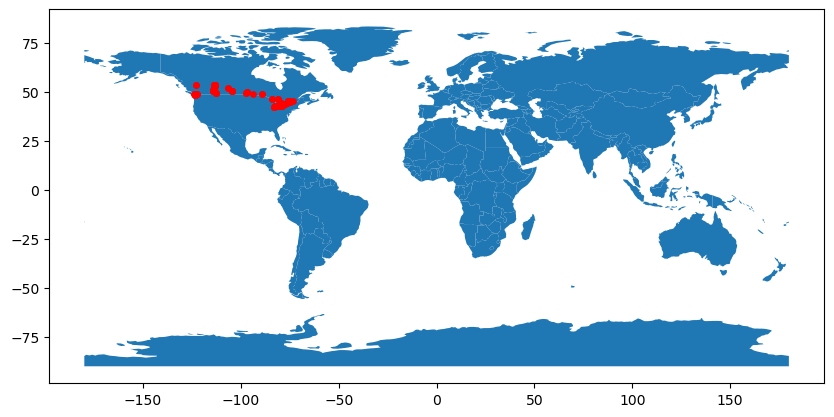

In [146]:
world_countries = gpd.read_file("ne_110m_admin_0_countries.zip")
world_st_prov = gpd.read_file("ne_110m_admin_1_states_provinces.zip")

gdf_ca.plot(ax=world_countries.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

plt.savefig('world_ca.jpg')
world_countries.head()

In [148]:
world_st_prov.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-89.95766 47.28691, -90.13175 47.292..."
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -113.0595 49.00..."
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-97.22894 49.00089, -97.21414 48.902..."
3,Admin-1 scale rank,2,USA-3517,3517,US-HI,http://en.wikipedia.org/wiki/Hawaii,US,8,Hawaii,HI|Hawaii,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080..."
4,Admin-1 scale rank,2,USA-3518,3518,US-ID,http://en.wikipedia.org/wiki/Idaho,US,1,Idaho,ID|Idaho,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -115.9678 47.95..."


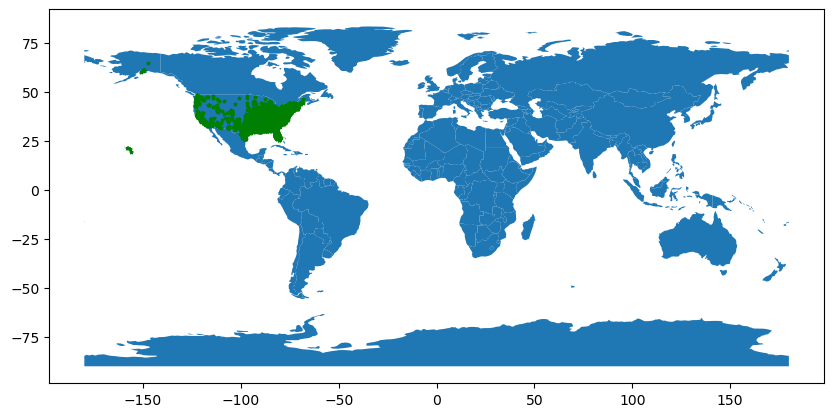

In [132]:
gdf_us.plot(ax=world_countries.plot(figsize=(10, 6)), marker='*', color='green', markersize=5);

plt.savefig('world_us_1.jpg')

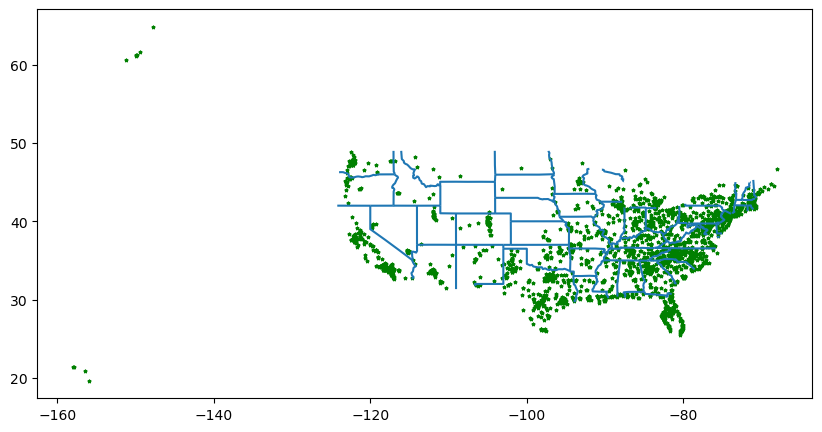

In [133]:
gdf_us.plot(ax=world_st_prov.plot(figsize=(10, 6)), marker='*', color='green', markersize=5);

plt.savefig('world_us_2.jpg')

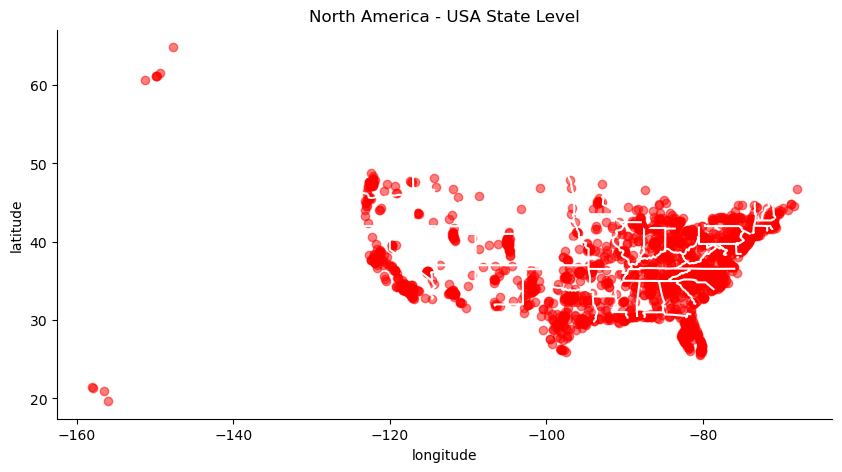

In [139]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'North America' we only plot, well,
# South America.
world_st_prov.query("ADM0_NAME == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf_us.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('North America - USA State Level')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

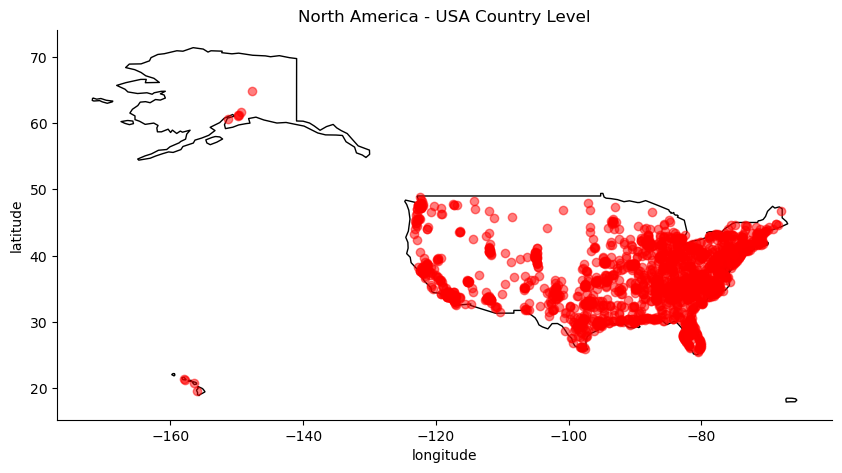

In [140]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'North America' we only plot, well,
# South America.
world_countries.query("SOVEREIGNT == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf_us.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('North America - USA Country Level')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

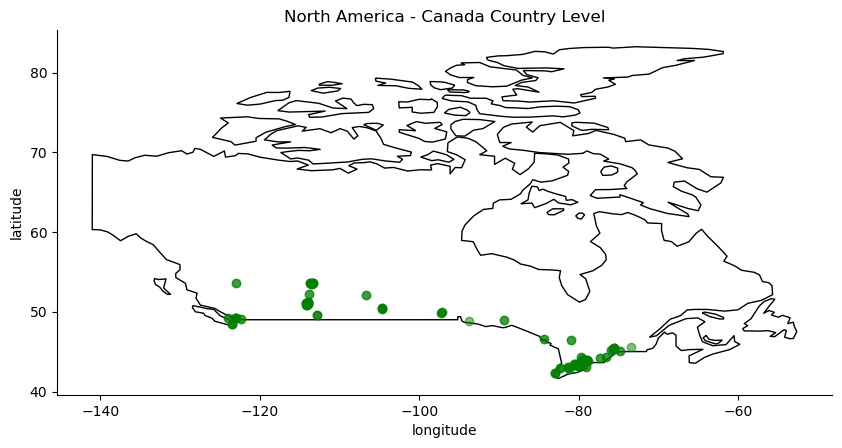

In [142]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'North America' we only plot, well,
# South America.
world_countries.query("SOVEREIGNT == 'Canada'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf_ca.plot(ax=gax, color='green', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('North America - Canada Country Level')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()